## Задание на курсовой проект
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)


Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Program Files\Python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Функция валидации и визуализации результатов обучения

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Овервью численных данных датасета

In [3]:
train_dataset = pd.read_csv('train.csv', sep=',')
train_dataset.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
train_dataset.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [5]:
train_dataset.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Овервью обжектов

In [7]:
train_dataset_obj_features = train_dataset.select_dtypes(include='object')
train_dataset_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,B


In [8]:
train_dataset_obj_features['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [9]:
train_dataset_obj_features['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [10]:
train_dataset_obj_features['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Заменим обжект-переменные на целое число

In [11]:
train_dataset['Ecology_2_bin'] = train_dataset['Ecology_2'].replace({'A':0, 'B':1})
train_dataset['Ecology_3_bin'] = train_dataset['Ecology_3'].replace({'A':0, 'B':1})
train_dataset['Shops_2_bin'] = train_dataset['Shops_2'].replace({'A':0, 'B':1})

In [12]:
district_size = train_dataset['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [13]:
train_dataset = train_dataset.merge(district_size, on='DistrictId', how='left')
train_dataset.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,NaN,0,11,B,184966.930730,1,1,1,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,87
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,97


Отработка пропусков для числовых данных

In [14]:
len(train_dataset) - train_dataset.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Ecology_2_bin       0
Ecology_3_bin       0
Shops_2_bin         0
DistrictSize        0
dtype: int64

In [15]:
train_dataset.loc[train_dataset['LifeSquare'].isnull(), 'LifeSquare'] = train_dataset['LifeSquare'].median()

In [16]:
train_dataset.loc[train_dataset['Healthcare_1'].isnull(), 'Healthcare_1'] = train_dataset['Healthcare_1'].median()

Промежуточный итог

In [17]:
train_dataset.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000


В глаза бросаются следующие неточности:
Имеются значения HouseYear разного порядка,
Необходимо проверить, чтобы значение Floor не превышало HouseFloor, а также сумму площадей LifeSqu & KitchenSqu

Обработаем поле HouseYear. Просмотрим, какие имеются аномалии в данных:

In [18]:
bigvalues1 = train_dataset.query('HouseYear > 2019')
bigvalues1['HouseYear'].value_counts()

2020        19
20052011     1
4968         1
Name: HouseYear, dtype: int64

Один тип имеет следующий год, остальные 2 некорректно распарсены. Поскольку в задаче не указано наличие в списках новостроек, 
оставим значения с 2020, предполагая, что это новостройки. Для 20052011 поделим на 10000 и оставим целую часть, для 4968 приравняем к 1949

In [19]:
train_dataset.loc[train_dataset['HouseYear'] == 20052011, 'HouseYear'] = 20052011 // 10000

In [20]:
train_dataset.loc[train_dataset['HouseYear'] == 4968, 'HouseYear'] = 1949

Промежуточный итог

In [21]:
train_dataset.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,8.526700,12.609400,1984.863800,0.118858,...,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,5.241148,6.775974,18.414238,0.119025,...,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1974.000000,0.017647,...,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2001.000000,0.195781,...,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000


Обработаем поле Floor в соответствии с HouseFloor. Просмотрим, какие имеются аномалии в данных:

In [22]:
bigvalues2 = train_dataset.query('Floor > HouseFloor')
len(bigvalues2)

1825

Таких набралось 1825. Приведем их номер этажа к его максимальному

In [23]:
train_dataset.loc[train_dataset['Floor'] > train_dataset['HouseFloor'], 'Floor'] = train_dataset['Floor'].median()

Промежуточный итог

In [24]:
train_dataset.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.266040,6.273300,7.849100,12.609400,1984.863800,0.118858,...,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,242.306600
std,4859.01902,43.587592,0.839512,21.058732,76.609981,28.560917,4.528596,6.775974,18.414238,0.119025,...,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,268.992652
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,...,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,1.000000
25%,4169.50000,20.000000,1.000000,41.774881,25.527399,1.000000,5.000000,9.000000,1974.000000,0.017647,...,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,55.000000
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,...,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,104.000000
75%,12592.50000,75.000000,2.000000,65.900625,41.427234,9.000000,10.000000,17.000000,2001.000000,0.195781,...,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,511.000000
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,...,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,851.000000


Проверим, что все сделано правильно

In [25]:
bigvalues2 = train_dataset.query('Floor > HouseFloor')
len(bigvalues2)

1146

По похожему принципу сравним площади. Для таких значений примем медианные значения

In [26]:
bigvalues3 = train_dataset.query('Square <= LifeSquare + KitchenSquare')
len(bigvalues3)

921

In [27]:
train_dataset['Square'].median()

52.51330992401352

In [28]:
train_dataset['LifeSquare'].median()

32.781260192155735

In [29]:
train_dataset['KitchenSquare'].median()

6.0

Заменим нулевые значеня этажа дома на медианные

In [30]:
train_dataset.loc[train_dataset['HouseFloor'] == 0, 'HouseFloor'] = train_dataset['HouseFloor'].median()

Проверим, что этаж квартиры не превысил количество этажей в доме

In [31]:
floor_outliers = train_dataset.loc[train_dataset['Floor'] > train_dataset['HouseFloor']].index

train_dataset.loc[floor_outliers, 'Floor'] = train_dataset.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [32]:
train_dataset['LifeSquare'].median()

32.781260192155735

Рассчитаем разницу между площадью всей квартиры и жилой площадью и кухни

In [33]:
square_med_diff = (train_dataset.loc[train_dataset['LifeSquare'].notnull(), 'Square'] -\
                   train_dataset.loc[train_dataset['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_dataset.loc[train_dataset['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

12.102486341214524

In [34]:
train_dataset.loc[train_dataset['LifeSquare'].isnull(), 'LifeSquare'] =\
train_dataset.loc[train_dataset['LifeSquare'].isnull(), 'Square'] -\
train_dataset.loc[train_dataset['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [35]:
train_dataset['LifeSquare'].median()

32.781260192155735

In [36]:
train_dataset.loc[train_dataset['Healthcare_1'].isnull(), 'Healthcare_1'] = train_dataset['Healthcare_1'].median()

In [37]:
train_dataset.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize']

In [39]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2','Ecology_2_bin', 'Ecology_3_bin']

additional_features = []

target_name = 'Price'

In [40]:
X = train_dataset[feature_names + additional_features]
y = train_dataset[target_name]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [42]:
X_train

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Ecology_2_bin,Ecology_3_bin
9239,1.0,39.458190,21.630224,8.0,9.0,17.0,1985,43,10621,1,30.0,2,1,1
6930,1.0,57.088640,23.298211,10.0,4.0,30.0,2014,36,6714,2,2672.0,0,1,1
8136,1.0,32.777610,22.448450,5.0,8.0,9.0,1967,24,4378,0,1036.0,1,1,1
3424,1.0,37.752079,20.140014,10.0,6.0,15.0,1976,28,7287,5,320.0,1,1,1
6518,1.0,31.702237,32.781260,1.0,7.0,12.0,1977,0,168,0,900.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,1.0,38.476449,23.803304,9.0,7.0,14.0,1971,21,4346,2,165.0,1,1,1
48,1.0,47.080100,46.807989,12.0,3.0,9.0,1977,2,475,0,900.0,0,1,1
8964,3.0,74.132699,45.351233,10.0,10.0,17.0,2009,33,5261,0,240.0,3,1,1
5944,2.0,63.911398,33.784613,12.0,2.0,17.0,2004,31,6137,4,900.0,0,1,1


Стандартизируем датасет

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [44]:
X_train_scaled

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Ecology_2_bin,Ecology_3_bin
0,-1.082108,-0.812218,-0.159461,0.045031,0.329993,0.619069,0.015988,1.049906,1.329469,-0.293169,-1.339655,0.441612,0.106399,0.168042
1,-1.082108,0.049209,-0.141476,0.102692,-0.696448,2.626474,1.583308,0.648947,0.347164,-0.251004,2.199045,-0.882237,0.106399,0.168042
2,-1.082108,-1.138632,-0.150639,-0.041460,0.124705,-0.616257,-0.956832,-0.038412,-0.240158,-0.335333,0.007783,-0.220312,0.106399,0.168042
3,-1.082108,-0.895579,-0.175529,0.102692,-0.285871,0.310237,-0.470422,0.190708,0.491229,-0.124511,-0.951229,-0.220312,0.106399,0.168042
4,-1.082108,-1.191175,-0.039229,-0.156782,-0.080583,-0.153010,-0.416377,-1.413129,-1.298644,-0.335333,-0.174376,-0.882237,0.106399,0.168042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,-1.082108,-0.860186,-0.136030,0.073862,-0.080583,0.155822,-0.740650,-0.210251,-0.248203,-0.251004,-1.158836,-0.220312,0.106399,0.168042
6696,-1.082108,-0.439810,0.112010,0.160353,-0.901736,-0.616257,-0.416377,-1.298569,-1.221457,-0.335333,-0.174376,-0.882237,0.106399,0.168042
6697,1.370158,0.881985,0.096303,0.102692,0.535281,0.619069,1.313081,0.477107,-0.018152,-0.335333,-1.058381,1.103537,0.106399,0.168042
6698,0.144025,0.382570,-0.028410,0.160353,-1.107024,0.619069,1.042853,0.362547,0.202094,-0.166675,-0.174376,-0.882237,0.106399,0.168042


Обучим модель

In [45]:
rf_model = RandomForestRegressor(random_state=50, criterion='mse', n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=50, verbose=0,
                      warm_start=False)

Посмотрим результат

Train R2:	0.961
Test R2:	0.714


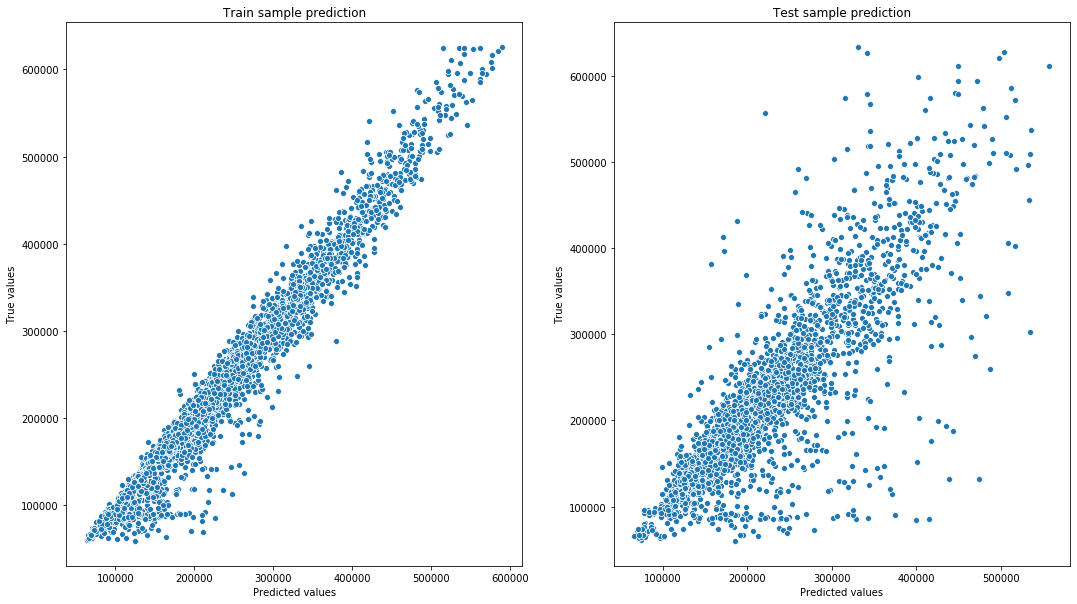

In [46]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Результат: 0,713 > 0.6 . Продолжаем работу

Проведем кросс-валидация

In [47]:
cv_score = cross_val_score(rf_model, X_test, y_test_preds, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.93102453, 0.94047382, 0.90621193])

Значения стремятся к 1. Продолжаем работу

Оценим важность признаков

In [48]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.400857
7,Social_1,0.114370
8,Social_2,0.100224
0,Rooms,0.083455
9,Social_3,0.067930
6,HouseYear,0.045172
2,LifeSquare,0.041035
10,Healthcare_1,0.040148
3,KitchenSquare,0.033486
5,HouseFloor,0.031311


Рассмотрим тестовый датасет и проведем аналогичную подготовку данных, что и для тренировочного

In [49]:
test_dataset = pd.read_csv('test.csv', sep=',')
test_dataset.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [50]:
test_dataset_obj_features = test_dataset.select_dtypes(include='object')
test_dataset_obj_features.head()

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B
3,B,B,B
4,B,B,A


In [51]:
test_dataset_obj_features['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [52]:
test_dataset_obj_features['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [53]:
test_dataset_obj_features['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

In [54]:
test_dataset['Ecology_2_bin'] = test_dataset['Ecology_2'].replace({'A':0, 'B':1})
test_dataset['Ecology_3_bin'] = test_dataset['Ecology_3'].replace({'A':0, 'B':1})
test_dataset['Shops_2_bin'] = test_dataset['Shops_2'].replace({'A':0, 'B':1})

In [55]:
district_size_test = test_dataset['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

In [56]:
test_dataset = test_dataset.merge(district_size_test, on='DistrictId', how='left')
test_dataset.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,NaN,0,0,B,1,1,1,91
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,1437,3,NaN,0,2,B,1,1,1,61
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,NaN,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,NaN,0,0,A,1,1,0,391


In [57]:
len(test_dataset) - test_dataset.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
Ecology_2_bin       0
Ecology_3_bin       0
Shops_2_bin         0
DistrictSize        0
dtype: int64

In [58]:
test_dataset.loc[test_dataset['LifeSquare'].isnull(), 'LifeSquare'] = test_dataset['LifeSquare'].median()

In [59]:
test_dataset.loc[test_dataset['Healthcare_1'].isnull(), 'Healthcare_1'] = test_dataset['Healthcare_1'].median()

In [60]:
bigvalues3 = test_dataset.query('Floor > HouseFloor')
len(bigvalues3)

884

In [61]:
test_dataset.loc[test_dataset['Floor'] > test_dataset['HouseFloor'], 'Floor'] = test_dataset['Floor'].median()

In [62]:
bigvalues3 = test_dataset.query('Square <= LifeSquare + KitchenSquare')
len(bigvalues3)

477

In [63]:
test_dataset.loc[test_dataset['HouseFloor'] == 0, 'HouseFloor'] = test_dataset['HouseFloor'].median()

In [64]:
floor_outliers_test = test_dataset.loc[test_dataset['Floor'] > test_dataset['HouseFloor']].index

test_dataset.loc[floor_outliers_test, 'Floor'] = test_dataset.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [65]:
square_med_diff = (test_dataset.loc[train_dataset['LifeSquare'].notnull(), 'Square'] -\
                   test_dataset.loc[train_dataset['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test_dataset.loc[train_dataset['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

12.188004289818807

In [66]:
test_dataset.loc[test_dataset['LifeSquare'].isnull(), 'LifeSquare'] =\
test_dataset.loc[test_dataset['LifeSquare'].isnull(), 'Square'] -\
test_dataset.loc[test_dataset['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [67]:
test_dataset['LifeSquare'].median()

32.92508663208161

In [68]:
test_dataset.loc[test_dataset['Healthcare_1'].isnull(), 'Healthcare_1'] = test_dataset['Healthcare_1'].median()

In [69]:
test_dataset.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize']

Определим перечень признаков для тествого дата-сета

In [70]:
feature_names_test = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2','Ecology_2_bin', 'Ecology_3_bin']

additional_features_test = []

Используем тестовый датасет для создания прогноза

In [71]:
X_test = test_dataset[feature_names + additional_features]
y_test_preds = rf_model.predict(X_test)

Объединим прогноз и Id для экспорта в csv

In [72]:
Result=pd.DataFrame({'id' : test_dataset['Id'], 'Price': y_test_preds})

Экспортируем в csv

In [73]:
Result.to_csv('GSeredin_predictions.csv', sep=',', index=False)